# 金融交易数据分析(欺诈检测)——分类算法(逻辑回归和支持向量机)

**Reference：**

[参考：EDA and Fraud detection](https://www.kaggle.com/netzone/eda-and-fraud-detection)


[数据集来源](https://www.kaggle.com/ntnu-testimon/paysim1/downloads/paysim1.zip)

## 数据集描述
该数据集取自某移动支付公司单月的转账日志。对于一条转账记录，预测其是否为欺诈行为。<br><br>


In [1]:
# 导入各种包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import skew, boxcox
import zipfile
import os

In [2]:
# 读取数据集
data = ('PS_20174392719_1491204439457_log.csv') 
df = pd.read_csv(data)

In [3]:
df.head()  # 数据预览 观察数据前五项

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()  # 查看数据统计信息

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()  # 数据集基本信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


数据列描述：<br>

| 名称 | 解释 |
|:--|:--|
| step | 对应现实中的时间单位（小时) |
| type | 转账类型 |
| amount | 转账金额 |
| nameOrig | 转账发起人 |
| oldbalanceOrg | 转账前发起人账户余额 |
| newbalanceOrig | 转账后发起人账户余额 |
| nameDest | 转账收款人 |
| oldbalanceDest | 转账前收款人账户余额。注意，收款人是商户时（M打头的收款人），没有该信息。 |
| newbalanceDest | 转账后收款人账户余额。注意，收款人是商户时（M打头的收款人），没有该信息。 |
| isFraud | 该转账行为是欺诈行为。这里的欺诈行为是指通过掌控客户账户，然后将其金额全部转账到另一个账户，最后全部提现。 |
| isFlaggedFraud | 商业模型为了控制大额转账并且标记为非法操作。在这里，非法操作是指单笔转账中，转账金额超过200,000。 |



## 探索性数据分析(EDA)

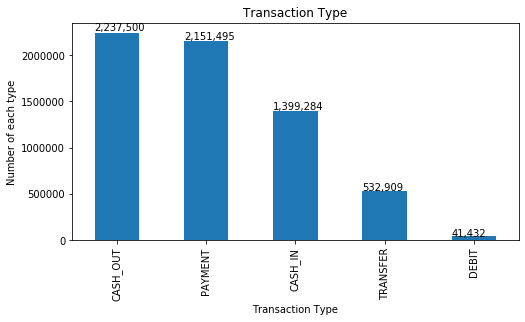

In [6]:
# 查看转账类型
p1 = df['type'].value_counts().plot(kind='bar', title='Transaction Type', figsize=(8, 4))
plt.xlabel('Transaction Type')
plt.ylabel('Number of each type')
# 添加标注
for i in p1.patches:
    p1.annotate(str(format(int(i.get_height()), ',d')), (i.get_x(), i.get_height()*1.01))


可以看到一共有五种交易类型，分别是**CASH_OUT(现金支出)，PAYMENT(商品支付)，CASH_IN（现金收入），TRANSFER（转账），DEBIT（取款）**，其中CASH_OUT和PAYMENT这两种交易记录是最多的，而DEBIT的记录则比较少，仅有41432条。

查看欺诈记录和被标记为欺诈的记录：

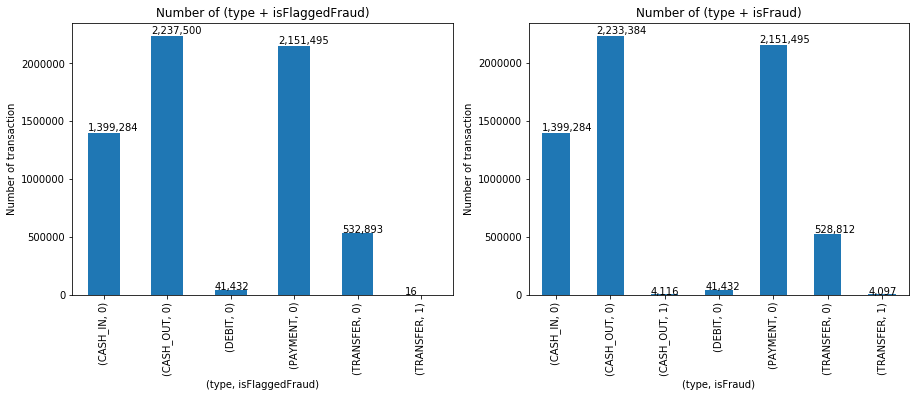

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # 画两幅图 画布大小为（15，5）
# 查看各个转账类型被标记为欺诈的记录
p2 = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar',  ax=axs[0])
p2.set_title('Number of (type + isFlaggedFraud)')
p2.set_xlabel('(type, isFlaggedFraud)')
p2.set_ylabel('Number of transaction')
for i in p2.patches:
    p2.annotate(str(format(int(i.get_height()), ',d')), (i.get_x(), i.get_height()*1.01))

# 查看各个转账类型的欺诈的记录
p3 = df.groupby(['type', 'isFraud']).size().plot(kind='bar', title='Number of (type + isFraud)', ax=axs[1])
p3.set_xlabel('(type, isFraud)')
p3.set_ylabel('Number of transaction')
for i in p3.patches: # 添加标注
    p3.annotate(str(format(int(i.get_height()), ',d')), (i.get_x(), i.get_height()*1.01))

In [8]:
# 查看被标记为欺诈的记录
df1 = df.loc[df['isFlaggedFraud']== 1]
print('被标记为欺诈的记录:')
print(df1['type'].value_counts())

# 查看实际上为欺诈的记录
df2 = df.loc[df['isFraud']== 1]
print('实际上为欺诈的记录:')
print(df2['type'].value_counts())

被标记为欺诈的记录:
TRANSFER    16
Name: type, dtype: int64
实际上为欺诈的记录:
CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


## 提出问题

通过上面的图表和数据，可以清晰看出在Transfer类型中，商业模型标记出的“欺诈”记录只有16条，而实际应该有4097条；CAST_OUT类型中被标记的欺诈记录为0而实质上有4116条是属于欺诈的。这说明目前的标记“欺骗”记录系统是十分不准确的。这个项目的目的就是**尽可能准确的预测/检测出欺诈记录**。接下来，我们着重分析Transfer类型的记录。

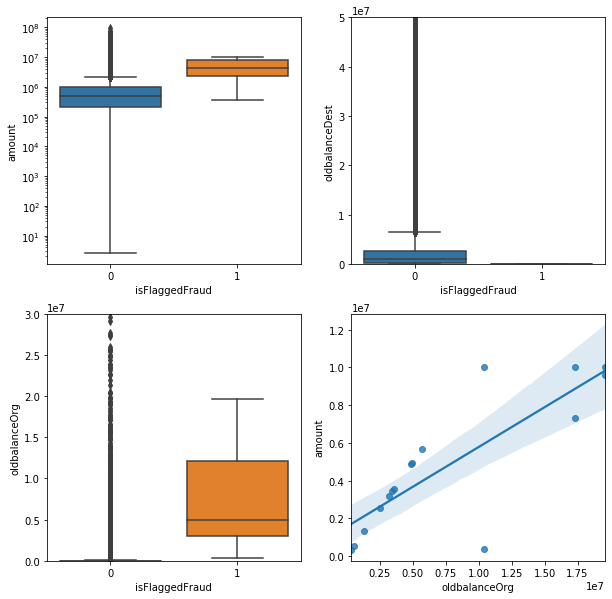

In [9]:
# 分析Transfer类型的记录
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
transfer_data = df[df['type'] == 'TRANSFER']

a = sns.boxplot(x='isFlaggedFraud', y='amount', data=transfer_data, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x='isFlaggedFraud', y='oldbalanceDest', data=transfer_data, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))

c = sns.boxplot(x='isFlaggedFraud', y='oldbalanceOrg', data=transfer_data, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))

d = sns.regplot(x='oldbalanceOrg', y='amount', data=transfer_data[transfer_data['isFlaggedFraud'] ==1], ax=axs[1][1])
plt.show()


## 数据预处理
因为只有CASH_OUT和TRANSFER这两类记录存在“欺诈”的数据，对这两类型记录的数据进行处理。

[`df.drop`的用法](https://blog.csdn.net/songyunli1111/article/details/79306639)

In [10]:
used_data = df[(df['type'] == 'TRANSFER') | (df['type'] == 'CASH_OUT')]
# 丢掉不用的数据列
used_data = used_data.drop(columns=['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'])

# 重新设置索引
used_data = used_data.reset_index(drop=True)

# 将type转换成类别数据，即 0表示CASH_OUT，1表示TRANSFER
type_label_encoder = preprocessing.LabelEncoder()
type_category = type_label_encoder.fit_transform(used_data['type'].values)
used_data['typeCategory'] = type_category

used_data.head() # 预览处理后的数据

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,typeCategory
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


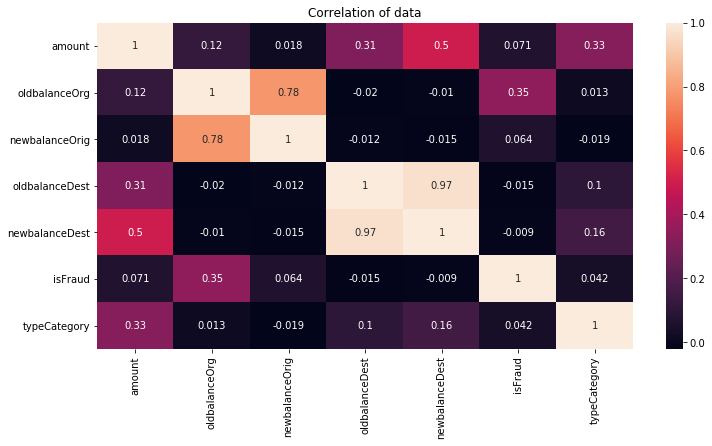

In [11]:
# 用热力图来表示变量间的相关系数矩阵
plt.figure(figsize=(12,6))
plt.title("Correlation of data")
sns.heatmap(used_data.corr(), annot=True)

可以看出相关系数大部分都不是很高。

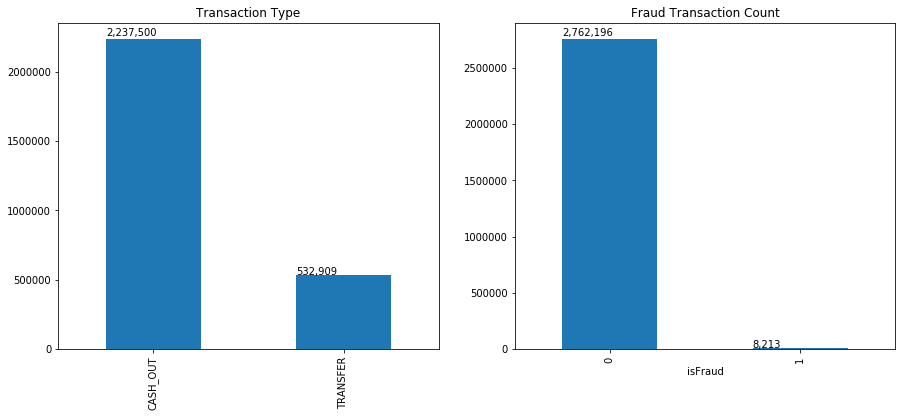

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# 查看转账类型记录个数
ax = used_data['type'].value_counts().plot(kind='bar', title="Transaction Type",ax=axs[0])
plt.xlabel('type')
for i in ax.patches:
    ax.annotate(str(format(int(i.get_height()), ',d')), (i.get_x(), i.get_height()*1.01))


# 查看转账类型中欺诈记录个数
ax = pd.value_counts(used_data['isFraud']).sort_index().plot(kind='bar', title="Fraud Transaction Count", ax=axs[1])
plt.xlabel('isFraud')
for i in ax.patches:
    ax.annotate(str(format(int(i.get_height()), ',d')), (i.get_x(), i.get_height()*1.01))


接下来将'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory'这六个变量作为解释变量X，'isFraud'作为被解释变量y进行建模：

In [13]:
# 准备数据
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory']
X = used_data[feature_names]
X.head() # 看看解释变量

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,typeCategory
0,181.00,181.0,0.0,0.0,0.00,1
1,181.00,181.0,0.0,21182.0,0.00,0
2,229133.94,15325.0,0.0,5083.0,51513.44,0
3,215310.30,705.0,0.0,22425.0,0.00,1
4,311685.89,10835.0,0.0,6267.0,2719172.89,1


In [14]:
y = used_data['isFraud']
y.head()  # 看看被解释变量

0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [15]:
# 处理不平衡数据
# 欺诈记录的条数
number_records_fraud = len(used_data[used_data['isFraud'] == 1])
# 欺诈记录的索引
fraud_indices = used_data[used_data['isFraud'] == 1].index.values

# 得到非欺诈记录的索引
nonfraud_indices = used_data[used_data['isFraud'] == 0].index

# 随机选取相同数量的非欺诈记录
random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

# 整合两类样本的索引
under_sample_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sample_data = used_data.iloc[under_sample_indices, :]
                          
                          
X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values

# 显示样本比例
print("非欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("采样记录总数数: ", len(under_sample_data))

非欺诈记录比例:  0.5
欺诈记录比例:  0.5
采样记录总数数:  16426


一共有8213个欺诈记录，再随机抽取8213个非欺诈记录用作训练数据，总共有16426条记录作为样本。

## 4. 数据建模

[`train_test_split`的用法](https://blog.csdn.net/CherDW/article/details/54881167):

```
X_train,X_test, y_train, y_test = cross_validation.train_test_split(train_data,train_target,test_size=0.4, random_state=0)
```

* 参数解释：

* `train_data`：所要划分的样本特征集

* `train_target`：所要划分的样本结果

* `test_size`：测试样本占比，如果是整数的话就是样本的数量

* `random_state`：随机数的种子(不填表示每次生成的随机数都不一样，填相同的数则每次生成的随机数都一样)

[ROC曲线概念](https://zh.wikipedia.org/wiki/ROC曲线)


### 4.1 逻辑回归

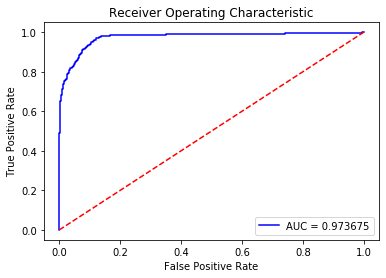

In [16]:
# 处理样本集
from sklearn.model_selection import train_test_split

# 分割训练集和测试集  取20%用作测试样本，随机数固定为1
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.2, random_state=1)

# 选用逻辑回归模型进行预测

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred_score = lr_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr,tpr)


# 作出ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.2 SVM

SVM的其中一个缺点是，在最差的情况下，样本数N的复杂度为`O(N^3)`，对于高效的实现，是`O(N^2)`。对于大量的训练样本，这种计算成本可能令人望而却步。因此，本节将样本集减少为欺诈记录和非欺诈记录各随机取样100条。

In [17]:
# number_records_fraud = len(used_data[used_data['isFraud'] == 1])
# # 欺诈记录的索引
# fraud_indices = used_data[used_data['isFraud'] == 1].index.values

# 得到非欺诈记录的索引
# nonfraud_indices = used_data[used_data['isFraud'] == 0].index

r_frauds = np.random.choice(fraud_indices, 100)
r_frauds = np.array(r_frauds)
# 随机选取相同数量的非欺诈记录
r_nonfrauds = np.random.choice(nonfraud_indices, 100)
r_nonfrauds = np.array(r_nonfrauds)

# 整合两类样本的索引
us_indices = np.concatenate([r_frauds, r_nonfrauds])
us_data = used_data.iloc[us_indices, :]
                          
                          
X_us = us_data[feature_names].values
y_us = us_data['isFraud'].values

# 显示样本比例
print("非欺诈记录比例: ", len(us_data[us_data['isFraud'] == 0]) / len(us_data))
print("欺诈记录比例: ", len(us_data[us_data['isFraud'] == 1]) / len(us_data))
print("采样记录总数数: ", len(us_data))

非欺诈记录比例:  0.5
欺诈记录比例:  0.5
采样记录总数数:  200


In [18]:
from sklearn.svm import SVC

X_tr, X_te, y_tr, y_te = train_test_split(X_us, y_us, test_size=0.2, random_state=1)
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_tr, y_tr)
y_pred = svclassifier.predict(X_te)

from sklearn.metrics import classification_report, confusion_matrix


[[17  0]
 [ 0 23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



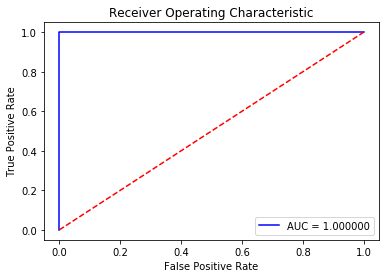

In [19]:
print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))

fpr, tpr, thresholds = roc_curve(y_te, y_pred)
roc_auc = auc(fpr,tpr)
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


待更新。。。
